<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/auto_gate_runs/auto_circuits_humongous_GRAM_POS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Quantum Circuits
#### dehls - pinballsurgeon@gmail.com

###Installs

In [1]:
# tensorflow quantum
!pip install --quiet tensorflow_quantum

# bloch sphere
!pip install --quiet qutip

# gdown drive for dans datasets
!pip install --upgrade --no-cache-dir gdown

     |████████████████████████████████| 10.5 MB 3.8 MB/s 
     |████████████████████████████████| 90 kB 7.0 MB/s 
     |████████████████████████████████| 90 kB 6.1 MB/s 
     |████████████████████████████████| 100 kB 7.5 MB/s 
     |████████████████████████████████| 6.1 MB 12.0 MB/s 
     |████████████████████████████████| 1.6 MB 31.6 MB/s 
     |████████████████████████████████| 576 kB 41.8 MB/s 
     |████████████████████████████████| 46 kB 1.6 MB/s 
     |████████████████████████████████| 641 kB 16.0 MB/s 
     |████████████████████████████████| 541 kB 44.5 MB/s 
     |████████████████████████████████| 541 kB 36.4 MB/s 
     |████████████████████████████████| 437 kB 46.1 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 93 kB 593 kB/s 
     |████████████████████████████████| 93 kB 920 kB/s 
     |████████████████████████████████| 93 kB 825 kB/s 
     |████████████████████████████████| 93 kB 836 kB/s 
     |█████████████████████████

###Imports

In [89]:
### standard dan-dards
import cirq
import sympy
import tensorflow
import numpy
import gc
import random
import gdown
import shutil
import os
from os import listdir
import cv2
from tensorflow.keras.utils import img_to_array
import pandas


# metric plotting
%matplotlib inline
from matplotlib import pyplot
from matplotlib.pyplot import figure

# tf quantum
import tensorflow_quantum

# circuit/operations visualizers
import qutip
from cirq.contrib.svg import SVGCircuit

###Experiment configuration and hyper-parameters

In [68]:
### Define your quantum machine learning experiment, the values here are optimized for best 'Colab free-tier' experience

# which dataset do you want to predict against?
# 1 = James Webb vs. Hubble sample classification
# 2 = Gram positive vs negative bacteria classification
# 3 = Wild fire from space classification
# 10 = MNIST written numerical classification
dataset_select = 2


# qubit grid sizes - how big do you want your circuit's grid size range to be
experiment_grid_sizes = [2, 4]

# experiment count - how many arrangements of gates, per qubit grid, to run
experiment_runs = 5

# gate combination range - how many, or few, combination of gates per experiemental run
min_gate_cobination = 1
max_gate_cobination = 4


# cirq gates to hyperparameterize
gate_mix = [cirq.CZ
           ,cirq.CNOT
           ,cirq.XX
           ,cirq.ISWAP
           ,cirq.ZZ
           ,cirq.SWAP
           ,cirq.YY
           ,cirq.CX]


# learning parameters
EPOCHS = 50
BATCH_SIZE = 5
ADAM_OPTIMIZER_LEARNING_RATE = 0.00011

# for MINST binary classifier, pick a single digit for TARGET and a single digit for JUNK
target_mnist_digit = 3
junk_mnist_digit = 4



###Helper Functions

In [4]:
### Initialize circuit - given a data and out qubit structure, build dynamic circuit
class circuit_struct():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [5]:
### Populate circuit with gates - given a combination of qubit grid size and gate population, build 
def create_quantum_model(gridSize, hyperGates):

    # cirq
    data_qubits = cirq.GridQubit.rect(gridSize, gridSize)
    readout = cirq.GridQubit(-1, -1)         
    circuit = cirq.Circuit()
    
    # prepare the readout qubit
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    # create qubit
    builder = circuit_struct(
        data_qubits = data_qubits,
        readout=readout)

    # buid layers
    for gate in hyperGates:

      # add specified gate and name
      builder.add_layer(circuit, gate, str(gate))
   
    # prepare the readout qubit
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [6]:
### image pixels to qubit
def convert_to_circuit(image):

    # flatten array
    values = numpy.ndarray.flatten(image)
    
    # establish 4x4 circuit
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()

    # 
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

In [7]:
### this example is for binary classification, so only keep one MNIST class/digit as target, and then one other as NON-TARGET/JUNK
def binary_filter(x, y):

    # identify rows that will be kept
    keep = (y == target_mnist_digit) | (y == junk_mnist_digit)
    
    # remove excess
    x, y = x[keep], y[keep]

    # establish target 1/0
    y = y == target_mnist_digit
 
    return x,y

In [72]:
### reveal experiment results per run
def experiment_reveal(log, run):

  fig, (ax1, ax2) = pyplot.subplots(2)
  pyplot.title('MSE Loss and Accuracy of %s gated Parametrized Quantum Circuit' % (log[run]['gates']), fontdict = {'fontsize' :16})

  ax1.plot(log[run]['history'].history['loss'])
  ax1.plot(log[run]['history'].history['val_loss'])
  ax1.set_ylabel('MAPL')

  ax2.plot(log[run]['history'].history['mean_squared_error'])
  ax2.plot(log[run]['history'].history['val_mean_squared_error'] )
  ax2.set_ylabel('MSE')
  ax2.set_xlabel('Epochs')
  
  fig = pyplot.gcf()
  fig.set_size_inches(12.5, 7.5)

  return log[run]['circuit']


In [9]:
### import dan ehlers' novel supplied datasource
def dans_data(url, path):

  # if directory exists, delete as to make room
  if os.path.isdir(path):
    shutil.rmtree(path, ignore_errors=True)

  # download from dan's drive, yay security exposure
  gdown.download_folder(url, quiet=True)

  return path

###Build experiment circuits and gates

In [65]:
### build experiment

experiment_design = []

# given experiement design parameters, build experiment(s)
for run in range(1, experiment_runs+1):

  # gate combination
  gate_combination = random.choices(gate_mix, k=random.randrange(min_gate_cobination, max_gate_cobination+1))

  # print random experiment gate participants
  print('Experiment %d Gates:' % run); print(gate_combination); print('')

  # build experiment
  experiment_design.append(gate_combination)


Experiment 1 Gates:
[cirq.SWAP]

Experiment 2 Gates:
[cirq.ZZ, cirq.CNOT, cirq.ZZ]

Experiment 3 Gates:
[cirq.CNOT, cirq.ZZ]

Experiment 4 Gates:
[cirq.CZ]

Experiment 5 Gates:
[cirq.ISWAP]



###Load Dataset(s)

In [11]:
### download data source as specified, manage datasource specific handlers here

# download drive share, per datasource selection
if dataset_select == 1:              # james webb vs. hubble telescope classification
  paths = dans_data("https://drive.google.com/drive/folders/1Ae4sZyMvJ02ht5O6UEBCpWg2R1e_Ihr3?usp=sharing",'/content/tele_source')
  trg_label_prefix = 'jw_'

elif dataset_select == 2:            # bacteria gram positive vs negative classification
  paths = dans_data("https://drive.google.com/drive/folders/1hhx1mEfWz-ThviwOqXK63v3wy2J7xV2c?usp=sharing",'/content/bact_source')
  trg_label_prefix = 'pos_'

elif dataset_select == 3:            # wild fire classification
  paths = dans_data("https://drive.google.com/drive/folders/1KRKEq8ZH7aKIVDRZQjknpEza2TnhiRxw?usp=sharing",'/content/fire_source')
  trg_label_prefix = 'pos_'


In [12]:
### ingest and process dehls created datasets
imagePaths = [paths +'/' + f for f in listdir(paths)]
data = []
labels = []

imagePaths = sorted(list(imagePaths))
print(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (28, 28))
    image = img_to_array(image)
    data.append(image)

    if trg_label_prefix in imagePath:
      labels.append(0)
    else:
      labels.append(1)

data = numpy.array(data, dtype="float") / 255.0

['/content/bact_source/neg_01.png', '/content/bact_source/neg_02.png', '/content/bact_source/neg_03.png', '/content/bact_source/neg_04.png', '/content/bact_source/neg_05.png', '/content/bact_source/neg_06.png', '/content/bact_source/neg_07.png', '/content/bact_source/neg_08.png', '/content/bact_source/neg_09.png', '/content/bact_source/neg_10.png', '/content/bact_source/neg_11.png', '/content/bact_source/neg_12.png', '/content/bact_source/neg_13.png', '/content/bact_source/neg_14.png', '/content/bact_source/neg_15.png', '/content/bact_source/neg_16.png', '/content/bact_source/neg_17.png', '/content/bact_source/neg_18.png', '/content/bact_source/neg_19.png', '/content/bact_source/neg_20.png', '/content/bact_source/pos_01.png', '/content/bact_source/pos_02.png', '/content/bact_source/pos_03.png', '/content/bact_source/pos_04.png', '/content/bact_source/pos_05.png', '/content/bact_source/pos_06.png', '/content/bact_source/pos_07.png', '/content/bact_source/pos_08.png', '/content/bact_sour

In [13]:
### establish dataset, here the MNIST numerical yada-yada

# 1. import mnist digits
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

# 2. rescale images to [0 - 1]
x_train, x_test = x_train[..., numpy.newaxis]/255.0, x_test[..., numpy.newaxis]/255.0

# 3. quantum experiment is binary classification, so only keep two classes/digit examples
x_train, y_train = binary_filter(x_train, y_train)
x_test, y_test = binary_filter(x_test, y_test)

# 4. change dataset from which to predict against, with MANUAL CONVOLUTIONS
if (dataset_select < 10):       # non MNIST sources
  x_train = data + [numpy.flip(x) for x in data] + [numpy.rot90(x) for x in data] + [numpy.fliplr(x) for x in data] + [numpy.flipud(x) for x in data]
  x_test = [numpy.rot90(x) for x in data]
  y_train = numpy.array(labels) + numpy.array(labels) + numpy.array(labels) + numpy.array(labels) + numpy.array(labels)

  y_test = numpy.array(labels)

# 5. resize image
x_train_small = tensorflow.image.resize(x_train, (4,4)).numpy()
x_test_small = tensorflow.image.resize(x_test, (4,4)).numpy()

# 6. convert circuit pixels/cells into individual qubits
x_train_circ = [convert_to_circuit(x) for x in x_train_small]
x_test_circ = [convert_to_circuit(x) for x in x_test_small]

# 7. convert to qubit imagery into tensors
x_train_tfcirc = tensorflow_quantum.convert_to_tensor(x_train_circ)
x_test_tfcirc = tensorflow_quantum.convert_to_tensor(x_test_circ)

11501568/11490434 [==============================] - 0s 0us/step


###Tensorflow quantum network

In [14]:
### tensorflow callbacks, here specifically garbage collection as to reduce memory load below colab free tier
class mem_release(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()


In [70]:
### tensorflow quantum experimental gate combinatorial iterator 

# keep track of experiment conditions and results
experiment_count = 0
experiment_log = {}


for gates in experiment_design:
  for gridSize_int in experiment_grid_sizes:


    # initialize quantum circuit
    model_circuit, model_readout = create_quantum_model(gridSize_int, gates)


    # build tf model
    model = tensorflow.keras.Sequential([
        
        # input data circuit as tf.string
        tensorflow.keras.layers.Input(shape=(), dtype=tensorflow.string),

        # parameterized quantum circuit
        tensorflow_quantum.layers.PQC(model_circuit, model_readout),])


    # compile model and determine loss / optimizer approach, for this introductory we'll focus on memory
    model.compile(

        # loss, mean square error
        # loss=tensorflow.keras.losses.binary_crossentropy,
        loss=tensorflow.keras.losses.mean_absolute_percentage_error,

        # optimizer, Adam with specifiable learning rate
        optimizer=tensorflow.keras.optimizers.Adam(learning_rate=ADAM_OPTIMIZER_LEARNING_RATE),
      
        # metrics, accuracy
        metrics=[tensorflow.keras.metrics.mean_absolute_percentage_error
               , tensorflow.keras.metrics.mean_absolute_error
               , tensorflow.keras.metrics.mean_squared_error
               ]
      )
    
    # display model parameters
    print(''); print(''.join(str(gates))); print(model.summary())

    # train model for experiment, define training and validation populations, callbacks ect.
    experiment_history = model.fit(
        x_train_tfcirc,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[mem_release()
                  ,tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
        validation_data=(x_test_tfcirc, y_test)
        )

    # after training, evaluate final model representation against test set
    experiment_results = model.evaluate(x_test_tfcirc, y_test)

    # record experiment
    experiment_count += 1
    experiment_log[experiment_count] = {'circuit' : model_circuit       
                                       ,'gates'   : gates
                                       ,'history' : experiment_history
                                       ,'results' : experiment_results }
    


[cirq.SWAP]
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_35 (PQC)                (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
8/8 [==============================] - 49s 7s/step - loss: 7106308.0000 - mean_absolute_percentage_error: 7106308.0000 - mean_absolute_error: 2.5142 - mean_squared_error: 12.5708 - val_loss: 6934919.0000 - val_mean_absolute_percentage_error: 6934919.0000 - val_mean_absolute_error: 0.5139 - val_mean_squared_error: 0.5141
Epoch 2/50
8/8 [==============================] - 2s 309ms/step - loss: 6828767.0000 - mean_absolute_percentage_error: 6828767.0000 - mean_absolute_error: 2.5137 - mean_squared_error: 12.5684 - val_loss: 6683171.0000 - val_mean_absolute

##Circuit #1 - design and results

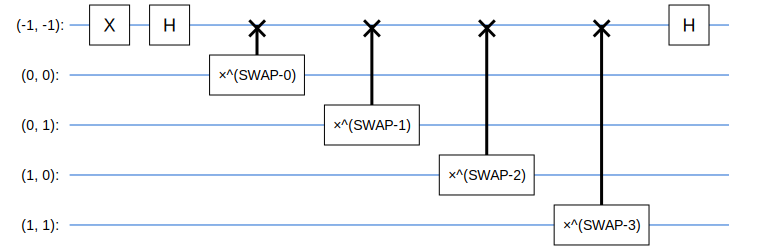

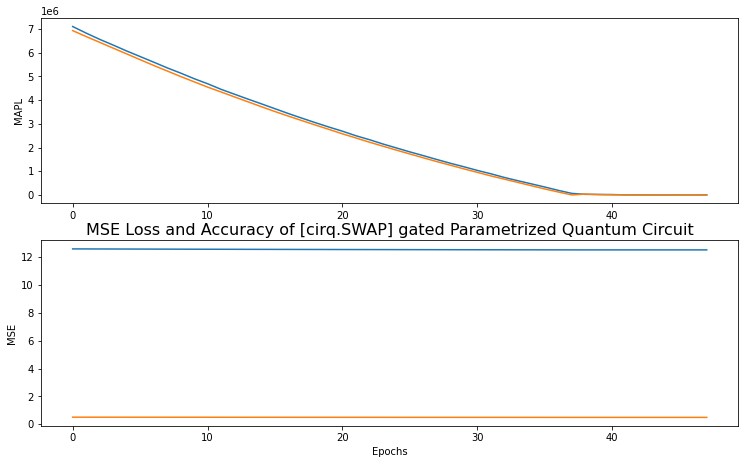

In [73]:
SVGCircuit(experiment_reveal(experiment_log, 1))

##Circuit #2 - design and results

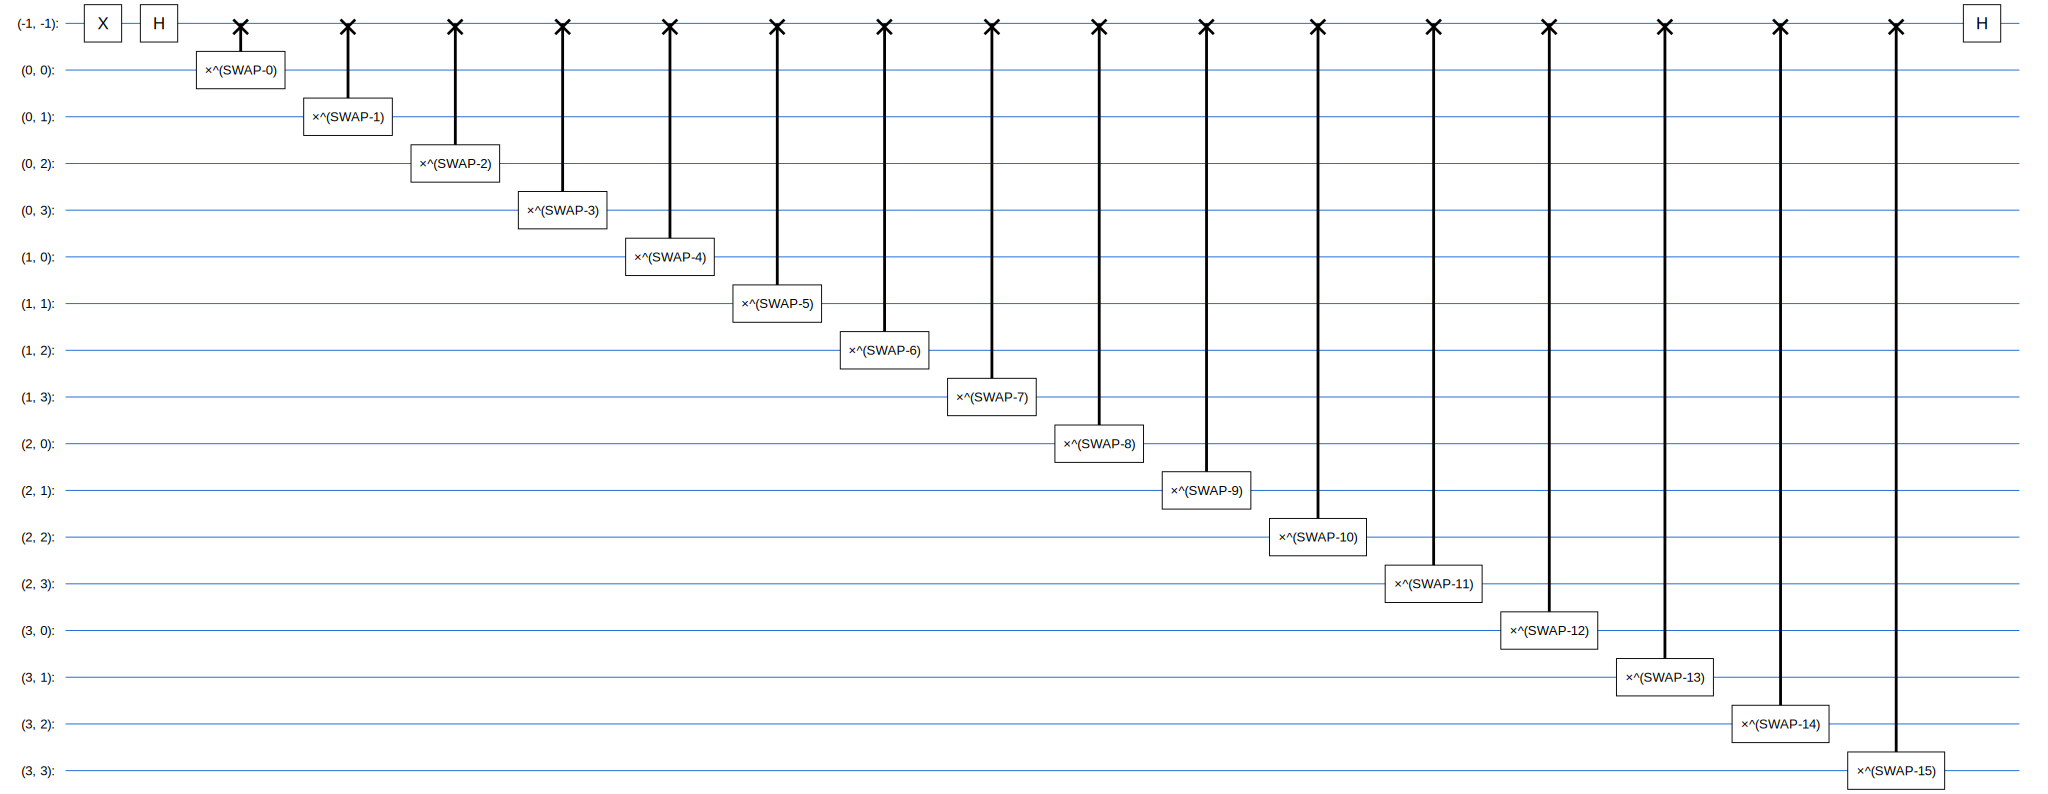

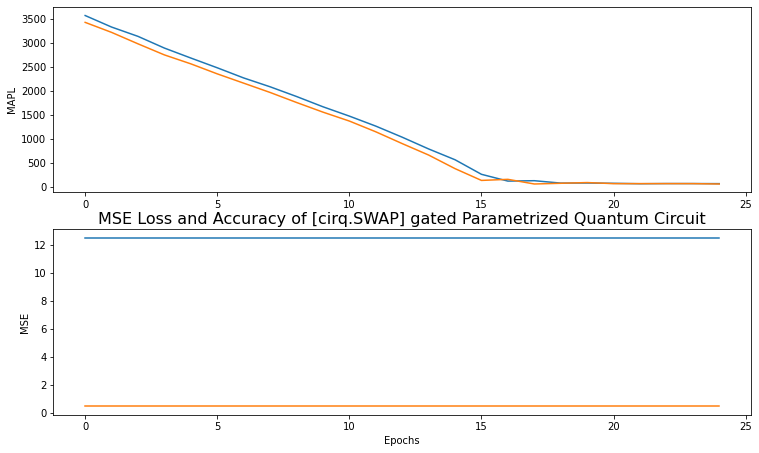

In [74]:
SVGCircuit(experiment_reveal(experiment_log, 2))

##Circuit #3 - design and results

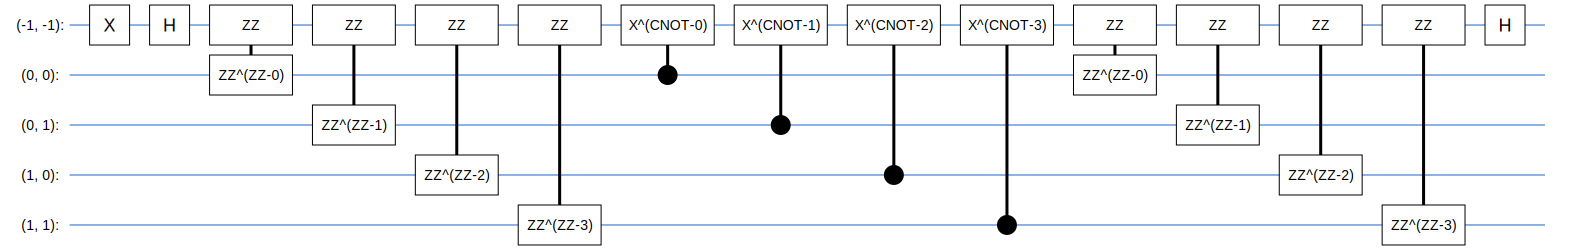

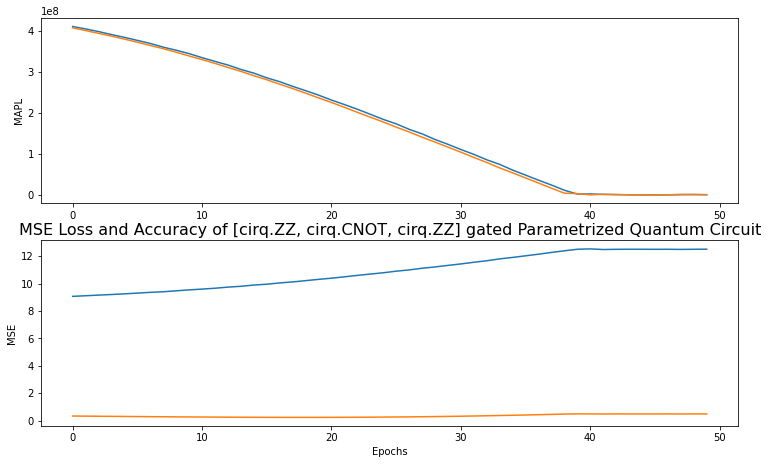

In [75]:
SVGCircuit(experiment_reveal(experiment_log, 3))

##Circuit #4 - design and results

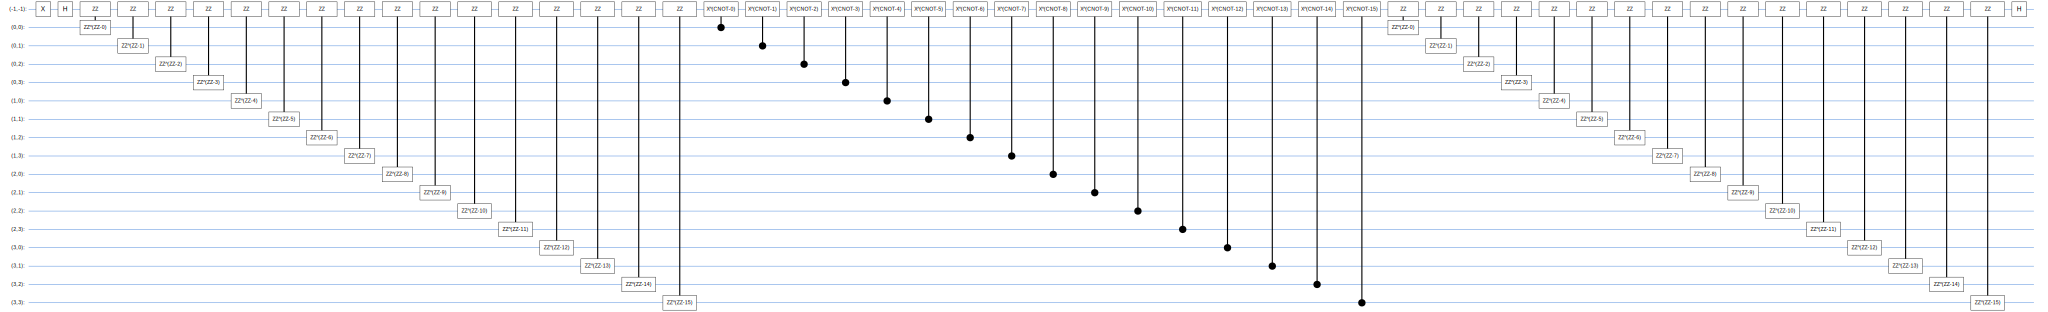

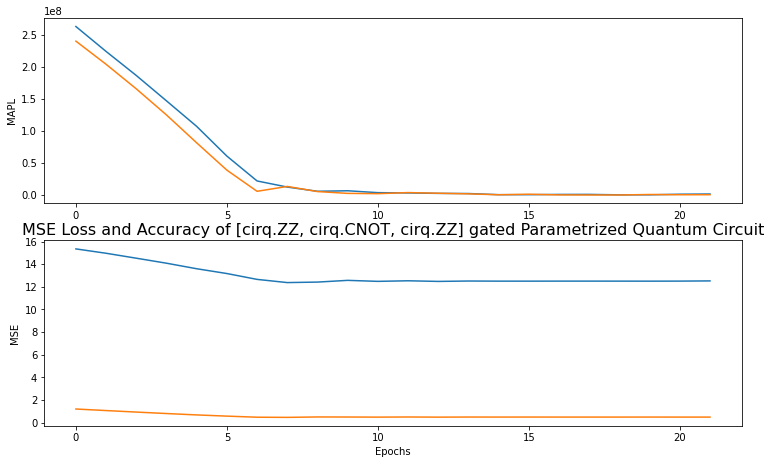

In [76]:
SVGCircuit(experiment_reveal(experiment_log, 4))

##Circuit #5 - design and results

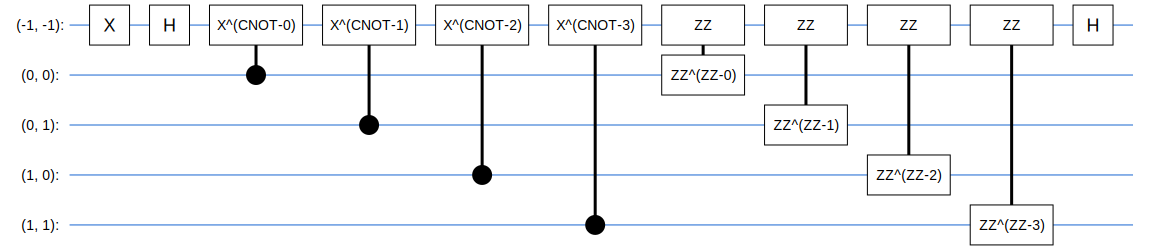

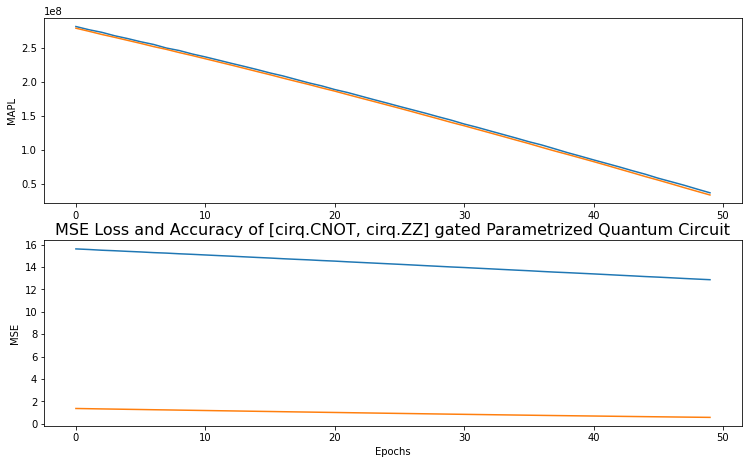

In [77]:
SVGCircuit(experiment_reveal(experiment_log, 5))

##Circuit #6 - design and results

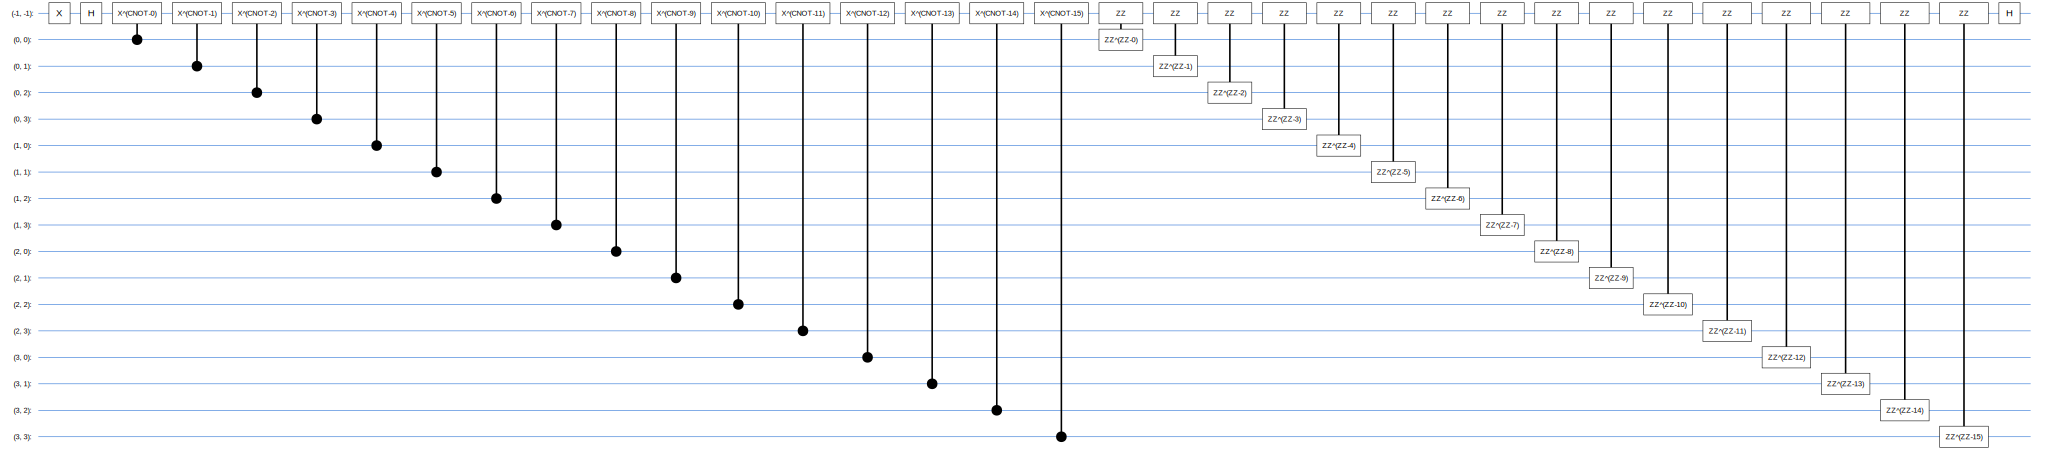

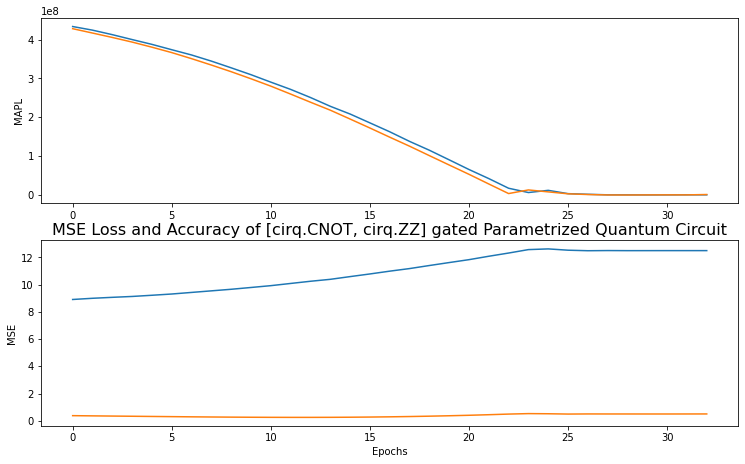

In [78]:
SVGCircuit(experiment_reveal(experiment_log, 6))

##Circuit #7 - design and results

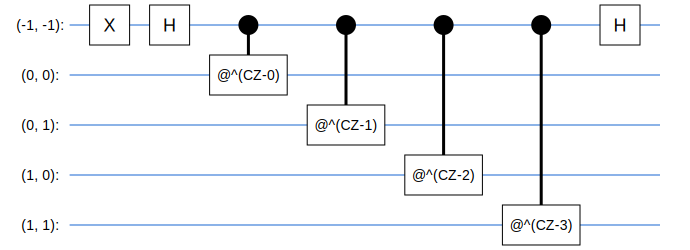

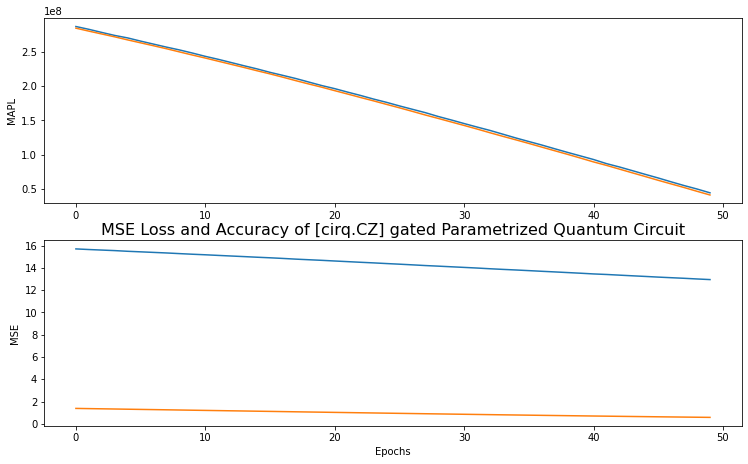

In [79]:
SVGCircuit(experiment_reveal(experiment_log, 7))

##Circuit #8 - design and results

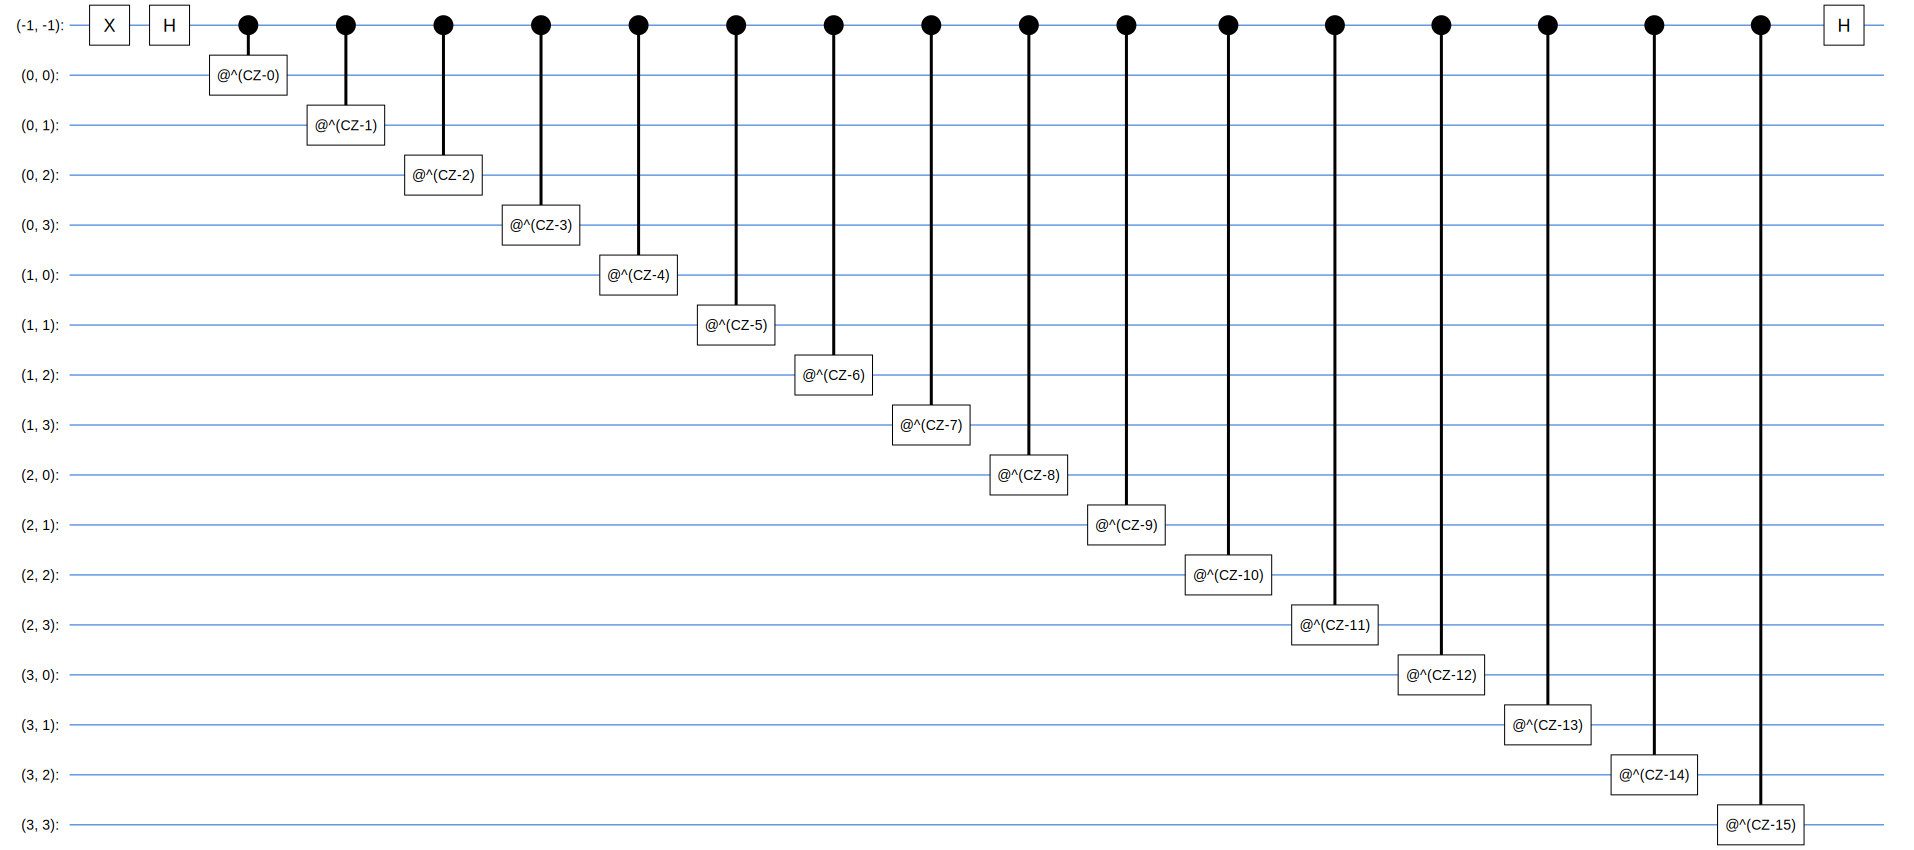

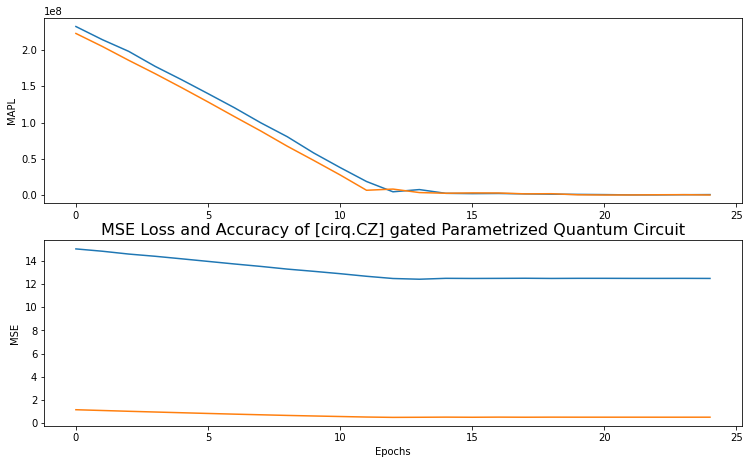

In [80]:
SVGCircuit(experiment_reveal(experiment_log, 8))

##Circuit #9 - design and results

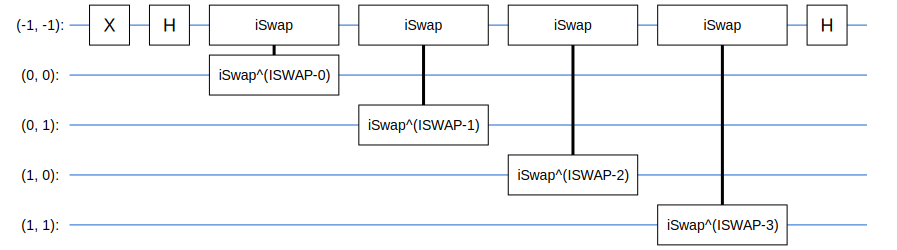

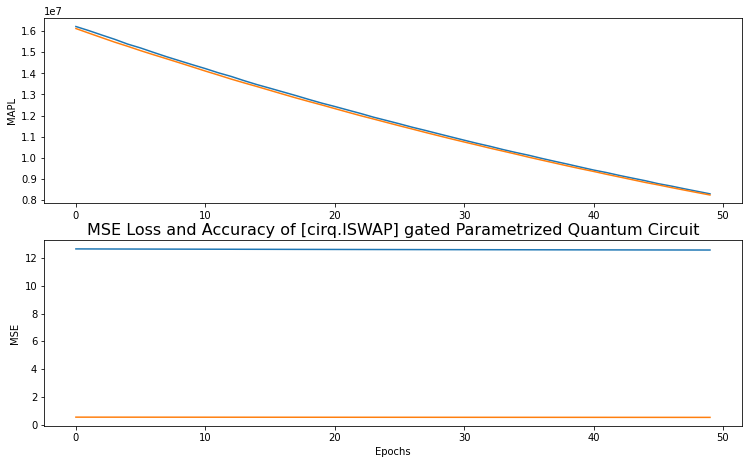

In [81]:
SVGCircuit(experiment_reveal(experiment_log, 9))

##Circuit #10 - design and results

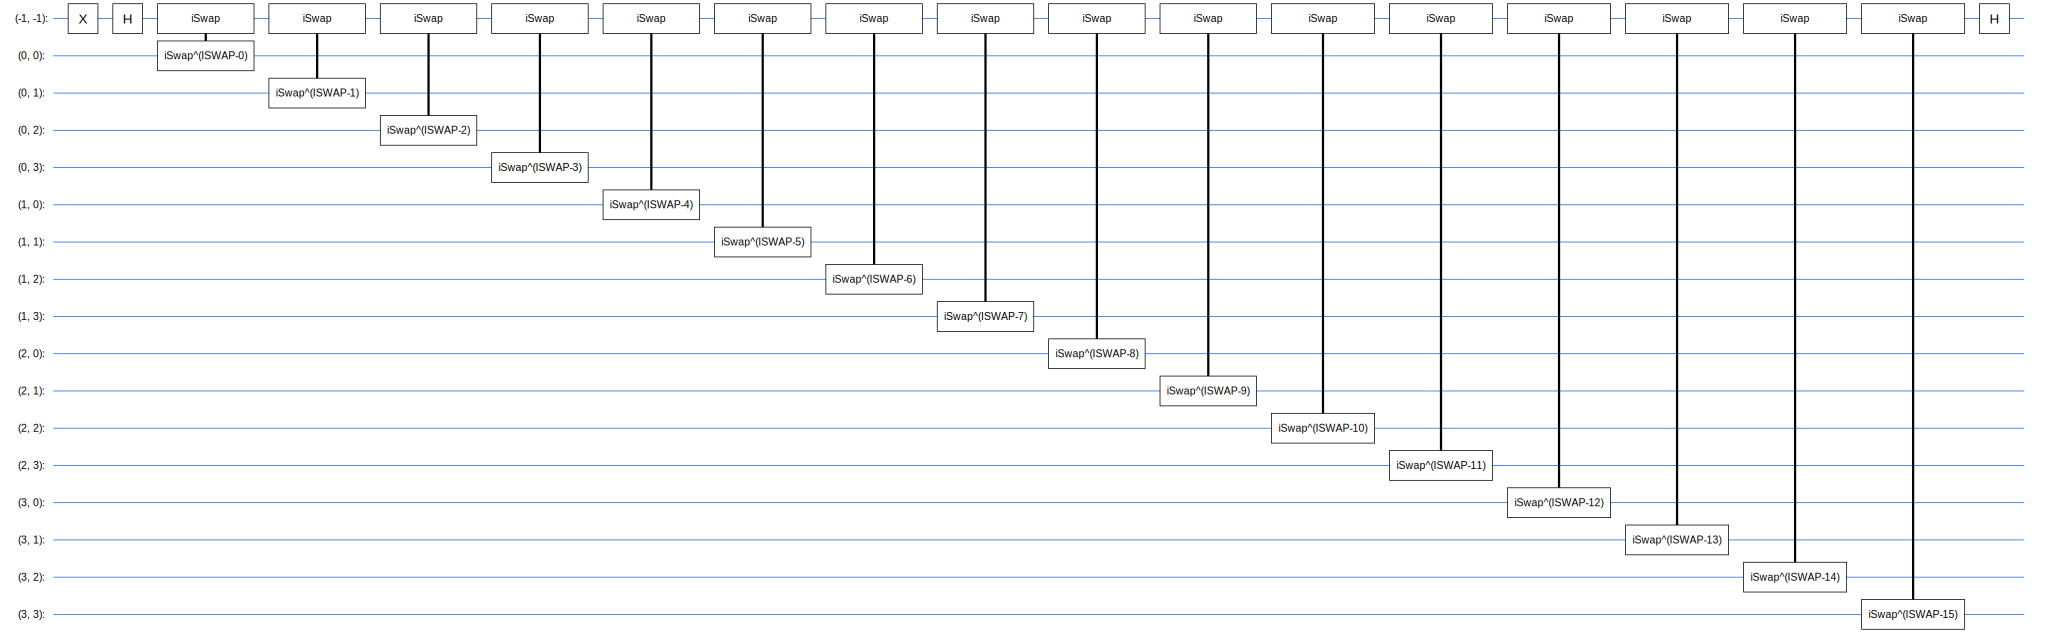

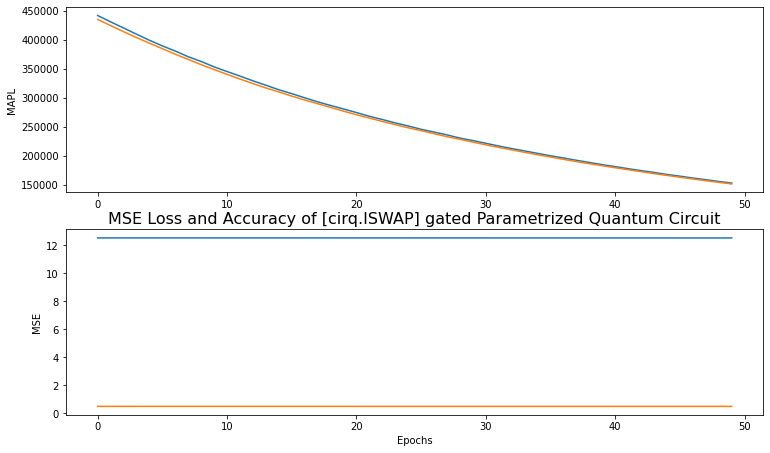

In [82]:
SVGCircuit(experiment_reveal(experiment_log, 10))

##Circuit #11 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 11))

##Circuit #12 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 12))

##Circuit #13 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 13))

##Circuit #14 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 14))

##Circuit #15 - design and results

In [ ]:
SVGCircuit(experiment_reveal(experiment_log, 14))

In [84]:
experiment_log

{1: {'circuit': (-1, -1): ───X───H───×────────────×────────────×────────────×────────────H───
                     │            │            │            │
(0, 0): ─────────────×^(SWAP-0)───┼────────────┼────────────┼────────────────
                                  │            │            │
(0, 1): ──────────────────────────×^(SWAP-1)───┼────────────┼────────────────
                                               │            │
(1, 0): ───────────────────────────────────────×^(SWAP-2)───┼────────────────
                                                            │
(1, 1): ────────────────────────────────────────────────────×^(SWAP-3)───────,
  'gates': [cirq.SWAP],
  'history': <keras.callbacks.History at 0x7f1835cd1990>,
  'results': [229.04678344726562,
   229.04678344726562,
   0.5000003576278687,
   0.5000003576278687]},
 2: {'circuit': (-1, -1): ───X───H───×────────────×────────────×────────────×────────────×────────────×────────────×────────────×────────────×────────────×───

In [136]:
#df = pandas.DataFrame.from_dict(experiment_log)
# print(df['results'])
#pandas.DataFrame(data=zip(df['results']),columns=['list1','list2','list3'])
#pandas.DataFrame(data=zip(df['results']))
#type(df['results'])
# ff = df['results']
#pandas.DataFrame(ff)
# df1 = df.explode(['gates', 'results'])

# df.explode(['gates', 'results'])

# print(df1)
#df1.explode('B')

#df.set_index(['gates'], drop = True).unstack('results')

g = []
for key, value in experiment_log.items():
  print('run #%d' % key)

  for sub_key, sub_value in value.items():
      print(sub_key)
      print(type(sub_value))

      try:
        for sub_sub_value in sub_value:
          print(sub_sub_value)
      except:
        pass

run #1
circuit
<class 'cirq.circuits.circuit.Circuit'>
   ╷ -1
╶──┼────
-1 │ X
   │
   ╷ -1
╶──┼────
-1 │ H
   │
   ╷ -1 0
╶──┼───────────────
-1 │ ×──┐
   │    │
0  │    ×^(SWAP-0)
   │
   ╷ -1 1
╶──┼───────────────
-1 │ ×──┐
   │    │
0  │    ×^(SWAP-1)
   │
   ╷ -1 0
╶──┼───────────────
-1 │ ×──┐
   │    │
1  │    ×^(SWAP-2)
   │
   ╷ -1 1
╶──┼───────────────
-1 │ ×──┐
   │    │
1  │    ×^(SWAP-3)
   │
   ╷ -1
╶──┼────
-1 │ H
   │
gates
<class 'list'>
SWAP
history
<class 'keras.callbacks.History'>
results
<class 'list'>
229.04678344726562
229.04678344726562
0.5000003576278687
0.5000003576278687
run #2
circuit
<class 'cirq.circuits.circuit.Circuit'>
   ╷ -1
╶──┼────
-1 │ X
   │
   ╷ -1
╶──┼────
-1 │ H
   │
   ╷ -1 0
╶──┼───────────────
-1 │ ×──┐
   │    │
0  │    ×^(SWAP-0)
   │
   ╷ -1 1
╶──┼───────────────
-1 │ ×──┐
   │    │
0  │    ×^(SWAP-1)
   │
   ╷ -1 2
╶──┼───────────────
-1 │ ×──┐
   │    │
0  │    ×^(SWAP-2)
   │
   ╷ -1 3
╶──┼───────────────
-1 │ ×──┐
   │    │
0  │    ×^